# MAD Plots

In [1]:
import os
os.chdir('../scripts')
from analysis_tools_cython import *
from astropy.stats import sigma_clip, sigma_clipped_stats
import pandas as pd

## Reading in Data

In [2]:
mad = pd.read_json("xrpdata/Sectors_MAD.json")

In [3]:
mad.head()

,1-1,1-2,1-3,1-4,2-1,2-2,2-3,2-4,3-1,3-2,...,24-3,24-4,25-1,25-2,25-3,25-4,26-1,26-2,26-3,26-4
0,0.001489,0.001328,0.001703,0.002827,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002134,0.002945,0.002894,0.003199,0.002653,0.003018,0.002630,0.001581
1,0.000994,0.000875,0.001072,0.001785,0.001056,0.001361,0.001337,0.002266,NaN,NaN,...,0.003243,0.006123,NaN,NaN,NaN,NaN,0.001349,0.001644,0.001562,0.001166
2,0.000740,0.000646,0.000782,0.001198,0.000817,0.001098,0.000870,0.001513,NaN,NaN,...,0.002234,0.004026,0.001311,0.001514,0.001804,0.001894,0.000776,0.000929,0.001316,0.000691
3,0.000797,0.000751,0.000873,0.001351,0.000664,0.000993,0.000612,0.002648,NaN,NaN,...,0.001458,0.001920,0.000976,0.000829,0.001314,0.001426,NaN,NaN,NaN,NaN
4,0.000793,0.000734,0.000847,0.001323,0.000689,0.000966,0.000715,0.001990,NaN,NaN,...,0.002027,0.002430,0.001140,0.000941,0.002351,0.001402,0.001231,0.001119,0.001168,0.000650


meta = pd.read_csv('../metadata-combined.txt',sep= " " ,header=None,names=['filepath','TIC_ID','Tmag','Sector','Camera','Chip','RA','DEC','test'])

In [5]:
meta[(meta.Sector == 1) & (meta.Camera == 1) & (meta.Chip == 1)].filepath.values

array(['hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000129712480_tess_v1.0_lc.fits',
       'hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000126786455_tess_v1.0_lc.fits',
       'hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000200646874_tess_v1.0_lc.fits',
       ...,
       'hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000139113054_tess_v1.0_lc.fits',
       'hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000389451346_tess_v1.0_lc.fits',
       'hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000159729856_tess_v1.0_lc.fits'],
      dtype=object)

### Example lightcurve

In [28]:
lc, lc_info = import_lightcurve("/storage/astro2/phrdhx/eleanor-lite-project-v2/s0001/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000126786455_tess_v1.0_lc.fits",drop_bad_points=False)

In [29]:
mad_arr = mad.loc[: len(lc) - 1, f"{lc_info[3]}-{lc_info[4]}"]

In [30]:
sig_clip = sigma_clip(mad_arr, sigma=3, masked=False)  # returns full length array

In [31]:
med_sig_clip = np.nanmedian(sig_clip)
med_sig_clip

0.0002887896

In [32]:
rms_sig_clip = np.nanstd(sig_clip)
rms_sig_clip

2.4448020910137446e-05

In [33]:
print(med_sig_clip + 3 * rms_sig_clip)

0.0003621336627304124


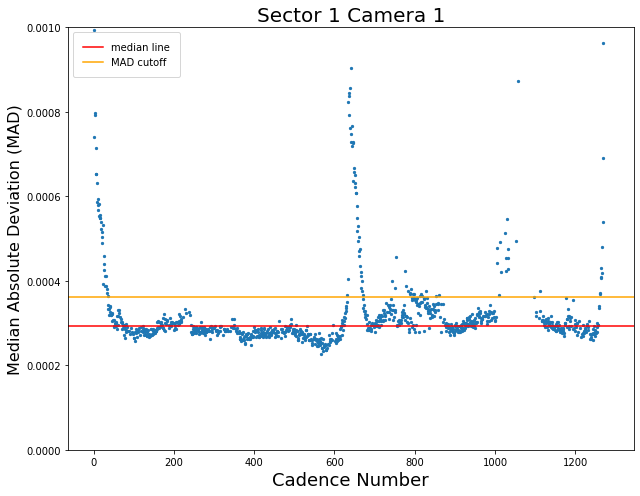

In [34]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(range(0, len(lc['TIME'])), mad_arr, s=5)

ax.axhline(np.nanmedian(mad_arr), c="r", label="median line")
# ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip + 3 * rms_sig_clip, c="orange", label="MAD cutoff")
ax.set_xlabel("Cadence Number", fontsize=18)
ax.set_ylabel("Median Absolute Deviation (MAD)", fontsize=16)
ax.set_title(f"Sector {lc_info[3]} Camera {lc_info[4]}", fontsize=20)
ax.set_ylim([0, 0.001])
ax.legend(borderpad=1, fontsize=10)

fig.tight_layout()
plt.show()

In [35]:
mad_cut = mad_arr.values < (med_sig_clip + 3 * (rms_sig_clip))

---

## Applying MAD cut to lightcurve
### Reading in bad times data

In [36]:
bad_times = xrpdata.load_bad_times()
bad_times = bad_times - 2457000
mad_df = xrpdata.load_mad()

In [37]:
mask = np.ones_like(lc['TIME'], dtype=bool)
for i in bad_times:
    newchunk = (lc['TIME'] < i[0]) | (lc['TIME'] > i[1])
    mask = mask & newchunk

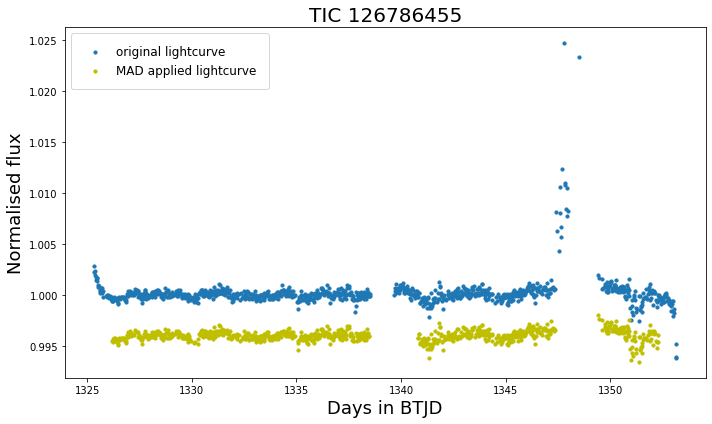

In [38]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.scatter(
    lc["TIME"][lc['QUALITY'] == 0],
    lc["PCA_FLUX"][lc['QUALITY'] == 0]/np.median(lc['PCA_FLUX']),
    label="original lightcurve",
    s=10,
)
# ax.scatter(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut]+0.025,c='blue',label='MAD and mask applied to lightcurve',s=5)
ax.scatter(
    lc["TIME"][(lc['QUALITY'] == 0) & mask & mad_cut],
    lc["PCA_FLUX"][(lc['QUALITY'] == 0) & mask & mad_cut]/np.median(lc['PCA_FLUX']) - 0.004,
    label="MAD applied lightcurve",
    s=10,
    color="y",
)

ax.set_xlabel("Days in BTJD", fontsize=18)
ax.set_ylabel("Normalised flux", fontsize=18)
ax.set_title(f"TIC {lc_info[0]}", fontsize=20)
ax.legend(loc="upper left", borderpad=1, fontsize=12)

fig.tight_layout()
#plt.savefig("poster/TIC159670453.png", transparent=True, dpi=300)
plt.show()

## Putting it altogther

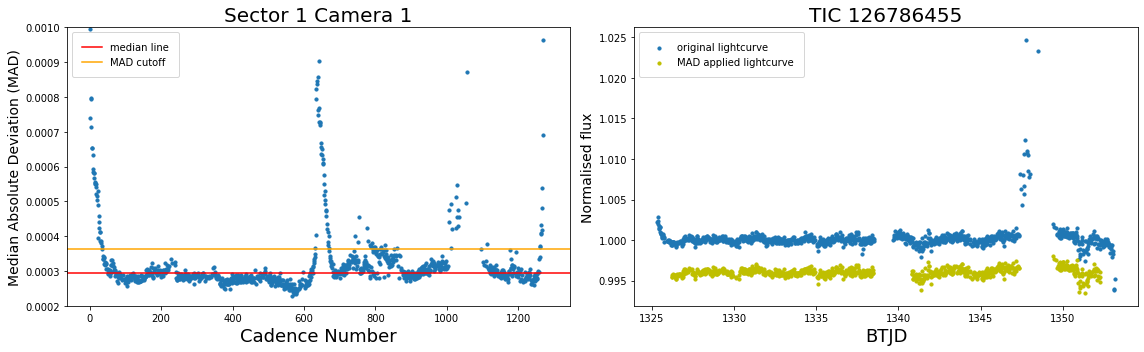

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot on the first subplot
ax1 = axes[0]
ax1.scatter(range(0, len(lc['TIME'])), mad_arr, s=10)
ax1.axhline(np.nanmedian(mad_arr), c="r", label="median line")
ax1.axhline(med_sig_clip + 3 * rms_sig_clip, c="orange", label="MAD cutoff")
ax1.set_xlabel("Cadence Number", fontsize=18)
ax1.set_ylabel("Median Absolute Deviation (MAD)", fontsize=14)
ax1.set_title(f"Sector {lc_info[3]} Camera {lc_info[4]}", fontsize=20)
ax1.set_ylim([0.0002, 0.001])
ax1.legend(borderpad=1, fontsize=10)

# Plotting the lightcurve
ax2 = axes[1]
ax2.scatter(
    lc["TIME"][lc['QUALITY'] == 0],
    lc["PCA_FLUX"][lc['QUALITY'] == 0] / np.median(lc['PCA_FLUX']),
    label="original lightcurve",
    s=10,
)

ax2.scatter(
    lc["TIME"][(lc['QUALITY'] == 0) & mask & mad_cut],
    lc["PCA_FLUX"][(lc['QUALITY'] == 0) & mask & mad_cut] / np.median(lc['PCA_FLUX']) - 0.004,
    label="MAD applied lightcurve",
    s=10,
    color="y",
)
#ax2.axhline(mad_line)
ax2.set_xlabel("BTJD", fontsize=18)
ax2.set_ylabel("Normalised flux", fontsize=14)
ax2.set_title(f"TIC {lc_info[0]}", fontsize=20)
ax2.legend(loc="upper left", borderpad=1, fontsize=10)
plt.savefig("../MAD.pdf", dpi=300, transparent=True,bbox_inches='tight')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()